In [1]:
%matplotlib inline

In [2]:
#
import nbodykit.lab as nb
from nbodykit.cosmology import Planck15
from scipy.interpolate import UnivariateSpline
import healpy as hp

In [3]:
import numpy as np

In [4]:
#
def pos2radec(pos, obs):
    x, y, z= (pos - obs).T
    r = (x**2+y**2+z**2) ** 0.5
    dec = np.arcsin(z / r)
    ra = np.arctan2(y, x)
    return ra, dec, r 

def r2z(cosmology, r1):
    zgrid = np.linspace(0, 9.0, 10000)
    rgrid = cosmology.comoving_distance(zgrid)
    spl = UnivariateSpline(rgrid, zgrid)
    return spl(r1)

class DESIFootprint:
    def __init__(self, desi_map):
        map = hp.read_map(desi_map)
        self.map = map
        
    def f(self, ra, dec):
        pix = hp.ang2pix(nside=32, phi=ra, theta=np.pi / 2 - dec)
        return self.map[pix]

In [5]:
ftp = DESIFootprint('/project/projectdirs/desi/mocks/GaussianRandomField/v0.0.4/desi-map.fits')

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [6]:
redshift = 0.0
cosmo = nb.cosmology.Planck15
Plin = nb.cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
b1 = 2.0
cat = nb.LogNormalCatalog(Plin=Plin, nbar=3e-2, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

In [7]:
class Mock:
    def __init__(self, pos, cosmo, ftp, obs):
        ra, dec, r = pos2radec(pos, obs=obs)
        z = r2z(cosmo, r)
        f = ftp.f(ra, dec)
        self.ra = ra
        self.dec = dec
        self.z = z
        self.f = f
        self.r = r

In [8]:
posrandom = np.random.uniform(size=(10*cat['Position'].shape[0],3))*1380
data = Mock(cat['Position'], Planck15, ftp, obs=[690, 690, 690])
random = Mock(posrandom, Planck15, ftp, obs=[690, 690, 690])

In [9]:
import matplotlib.pyplot as plt

In [10]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')
from syslss import hpixsum

(array([    72382.,    557256.,   1589932.,   3798287.,   7047831.,
         12131363.,  20089391.,  20990892.,  10977625.,   1582006.]),
 array([-0.43079798, -0.32690339, -0.22300879, -0.11911419, -0.0152196 ,
         0.088675  ,  0.1925696 ,  0.29646419,  0.40035879,  0.50425339,
         0.60814798]),
 <a list of 10 Patch objects>)

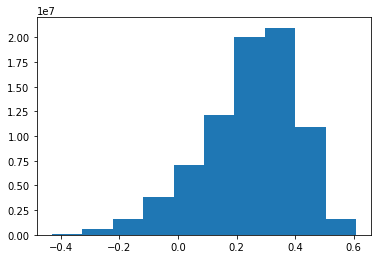

In [11]:
plt.hist(data.z)

In [12]:
m = (data.r < 690) & (data.f > 0.2)
n = (random.r < 690) & (random.f > 0.2)

In [13]:
datam = hpixsum(256, np.rad2deg(data.ra[m]), np.rad2deg(data.dec[m]))
randomm = hpixsum(256, np.rad2deg(random.ra[n]), np.rad2deg(random.dec[n]))

In [14]:
delta  = np.zeros(datam.shape)
mask   = randomm != 0.0
sf = datam[mask].sum()/randomm[mask].sum()
delta[mask] = datam[mask]/(randomm[mask]*sf) - 1.0

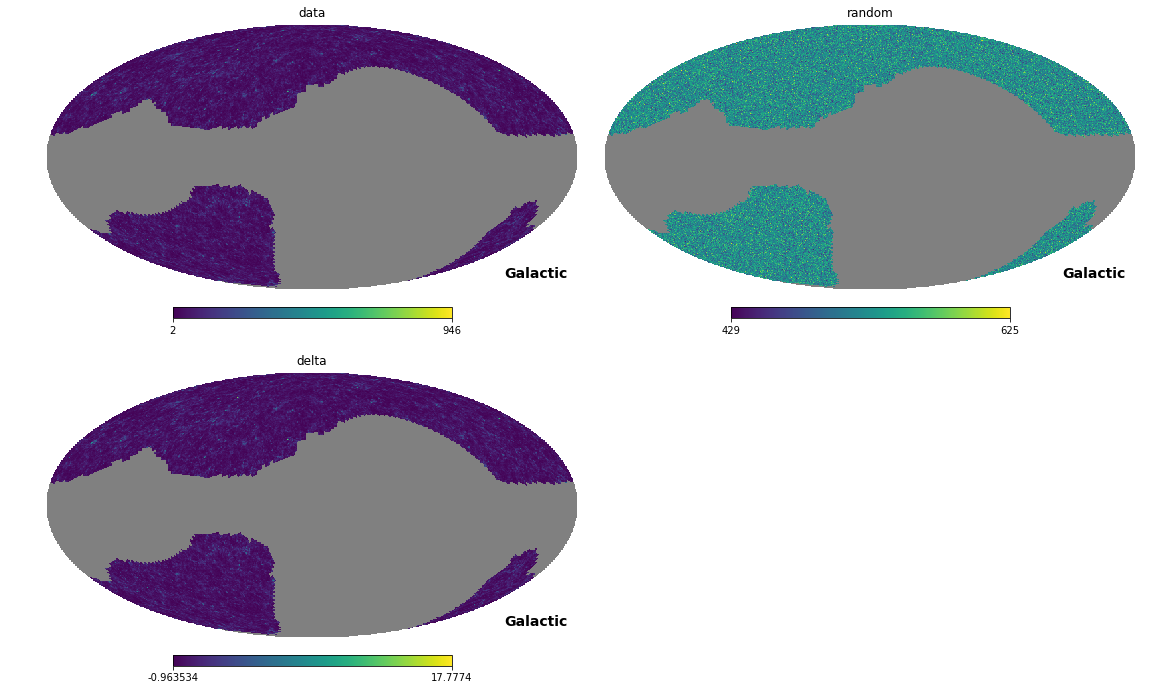

In [15]:
plt.figure(figsize=(20,25))
plt.subplots_adjust(wspace=0.0, hspace=0.1)
for i,(title, map_i) in enumerate([('data',datam), ('random',randomm), ('delta', delta)]):
    map_m = hp.ma(map_i.astype('f8'))
    map_m.mask = np.logical_not(mask)
    plt.subplot(421+i)
    hp.mollview(map_m.filled(), title=title, hold=True, coord=['C','G'])

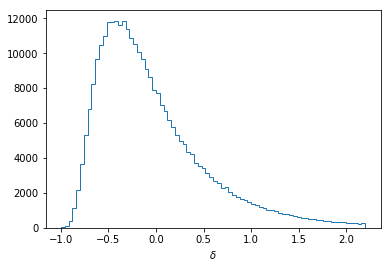

In [16]:
plt.xlabel(r'$\delta$')
_=plt.hist(delta[mask], bins=80, range=(-1, 2.2), histtype='step')

In [17]:
from syslss import AngularClustering2D

In [18]:
randomm.max()

625

In [19]:
mock1 = AngularClustering2D(datam.astype('f8'), randomm.astype('f8')/89, hpmap=True, nside=256)

In [20]:
xicl = mock1.run()

In [21]:
xicl.keys()

dict_keys(['attr', 'cl', 'xi'])

In [22]:
xicl['attr']

{'lmax': 767, 'nside': 256}

(1, 1122.0184543019618)

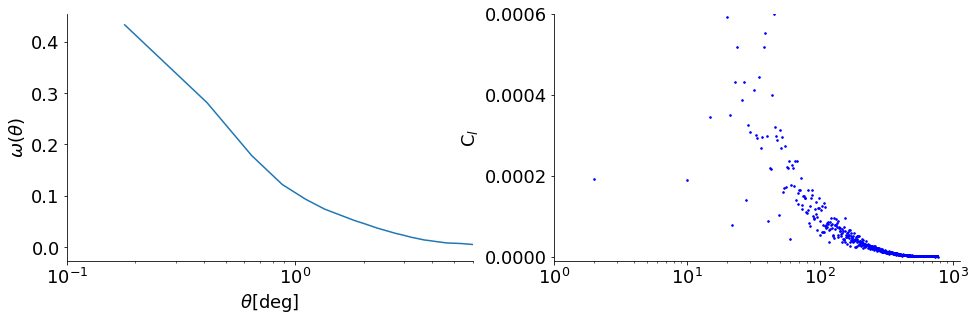

In [23]:
xi = np.copy(xicl['xi'])
cl = np.copy(xicl['cl'])
plt.rc('font', size=18)
plt.rc('axes.spines', right=False, top=False)
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(xi[0], xi[1])
plt.xlim(0.1, 6)
plt.xscale('log')
plt.ylabel(r'$\omega(\theta)$')
plt.xlabel(r'$\theta$[deg]')
plt.subplot(222)
plt.scatter(cl[0], cl[1], 10.0, marker='.', color='b')
plt.ylim([-1.e-5, 0.0006])
plt.xscale('log')
plt.ylabel(r'C$_{l}$')
plt.xlim(xmin=1)
# plt.yscale('log')